# Metrics per True Contamination Rate (Figure 4)
Shows the evolution of F1-score, AUC and AVPR according to the true contamination rate of the test set.

You can change the dataset by changing the *dataset_name* variable in the second cell of the notebook.

In [1]:
import os
import sys

import numpy as np
from tqdm import tqdm

from sklearn import metrics
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score, confusion_matrix

from matplotlib import pyplot as plt

from utils.datasets import load_dataset, normalize_data
from utils.helpers import get_model_scores, get_threshold, get_subset, cont_to_anomalies_per_clean_sample
from utils.protocols import algo2
from utils.scores import get_precision_recall_f1score, get_auc, get_avpr

In [2]:
img_format = 'pdf'
dpi = 512

# Choose the dataset to analyse
dataset_name = "arrhythmia"  # "arrhythmia", "thyroid" or "kddcup"
fig_title = {
    "thyroid": "Thyroid",
    "arrhythmia": "Arrhythmia",
    "kddcup": "KDD Cup"
}

n_runs = 100  # number of runs to do to have a good std estimation
n_points = 100  # number of points calculated to draw each curve
test_size = 0.2

## Computations

In [3]:
x, y = load_dataset(dataset_name)

f1_scores = None
aucs = None
avprs = None
contamination_rates = None

for j in tqdm(range(n_runs)):
    if dataset_name == "kddcup":  # Trains only on a subset of the kddcup for computational reasons
        x_run, y_run = get_subset(x[y==0], y[y==0])
        x_run = np.r_[x_run, x[y == 1]]
        y_run = np.r_[y_run, y[y == 1]]
    else:
        x_run, y_run = x.copy(), y.copy()
    clf = OneClassSVM(gamma="auto", nu=0.9)
    y_test, s_test, _ = algo2(x_run, y_run, test_size, clf, compute_metrics=False)
    
    s_normal = s_test[y_test==0]
    s_anomaly = s_test[y_test==1]
    
    nb_normal = np.sum(1 - y_test)
    max_contamination = np.sum(y_test) / len(y_test)
    wanted_cont = np.linspace(0, max_contamination, n_points)
    nb_anomalies = sorted(set((int(cont_to_anomalies_per_clean_sample(cont) * len(s_normal))
                             for cont in wanted_cont)))
    obtained_cont = nb_anomalies / (nb_anomalies + nb_normal)
    if contamination_rates is None:
        contamination_rates = obtained_cont
        f1_scores, aucs, avprs = (np.zeros((len(contamination_rates), n_runs)) for _ in range(3))
    else:
        assert np.array_equal(obtained_cont, contamination_rates), str(obtained_cont - contamination_rates)

    # Compute n_points points
    for i, (na, cont) in enumerate(zip(nb_anomalies, contamination_rates)):
        anomaly_idx = np.random.choice(len(s_anomaly), na, replace=False)
        s_anomaly_sub = s_anomaly[anomaly_idx]
    
        scores = np.r_[s_normal, s_anomaly_sub]
        labels = np.r_[np.zeros(len(s_normal)), np.ones(len(s_anomaly_sub))]
        
        # Compute a threshold based on the test set
        thresh = get_threshold(scores, cont)

        # Compute the binary predictions
        y_hat = (scores >= thresh).astype(int)
        
        # Get all metric values
        _, _, f1_score = get_precision_recall_f1score(labels, y_hat)
        auc = get_auc(labels, scores)
        avpr = get_avpr(labels, scores)
        
        f1_scores[i, j] = f1_score
        aucs[i, j] = auc
        avprs[i, j] = avpr
        
f1_means = np.mean(f1_scores, axis=1)
f1_stds = np.std(f1_scores, axis=1, ddof=1)

auc_means = np.mean(aucs, axis=1)
auc_stds = np.std(aucs, axis=1, ddof=1)

avpr_means = np.mean(avprs, axis=1)
avpr_stds = np.std(avprs, axis=1, ddof=1)

100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


## Plot

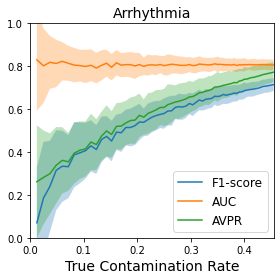

In [4]:
plt.figure(figsize=[4, 4])
plt.ylim([0.0, 1.0])
plt.xlim([0.0, np.max(contamination_rates)])

plt.plot(contamination_rates, f1_means, label='F1-score')
plt.fill_between(contamination_rates, f1_means-f1_stds, f1_means+f1_stds, alpha=0.3)

plt.plot(contamination_rates, auc_means, label='AUC')
plt.fill_between(contamination_rates, auc_means-auc_stds, auc_means+auc_stds, alpha=0.3)

plt.plot(contamination_rates, avpr_means, label='AVPR')
plt.fill_between(contamination_rates, avpr_means-avpr_stds, avpr_means+avpr_stds, alpha=0.3)

plt.legend(loc='lower right', fontsize=12)
plt.xlabel(f"True Contamination Rate", fontsize=14)
plt.title(fig_title[dataset_name], fontsize=14)

plt.tight_layout()
plt.savefig(f"./results/impact_true_contamination_{dataset_name}.{img_format}", format=img_format, dpi=dpi)
plt.show()